In [2]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import random
import datetime
import statsmodels as sm
import statsmodels.tsa.api as smt
from helper_functions import *

In [3]:
df = pd.read_csv('../data/final.csv')
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,0.0


In [4]:
df.shape

(59181090, 14)

In [5]:
ca_df = df[df.state_id == 'CA'].copy()

In [6]:
ca_df.shape

(23672436, 14)

In [7]:
ca_monthly_df = monthly_sales(ca_df)

In [8]:
ca_monthly_df.head()

,item_sales
date,
2011-01-31,12702.666667
2011-02-28,11360.750000
2011-03-31,10957.354839
2011-04-30,11033.466667
2011-05-31,10373.096774


In [9]:
ca_monthly_df.shape

(65, 1)

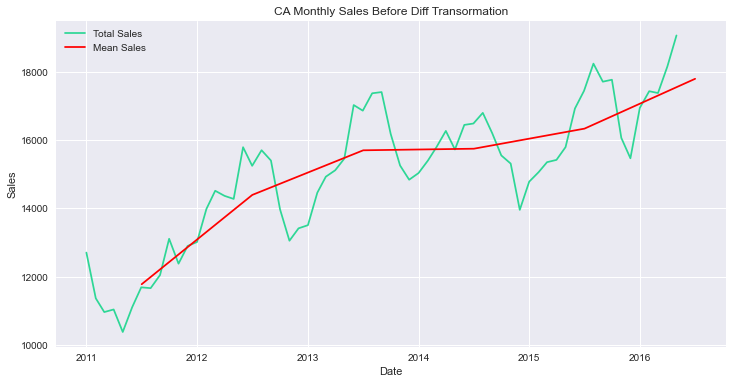

In [10]:
time_plot(ca_monthly_df.reset_index(), 'date', 'item_sales', 'CA Monthly Sales Before Diff Transormation')

In [11]:
ca_diff = get_diff(ca_monthly_df, 'ca')
ca_diff.head()

,item_sales,sales_diff
date,,
2011-02-28,11360.750000,-1341.916667
2011-03-31,10957.354839,-403.395161
2011-04-30,11033.466667,76.111828
2011-05-31,10373.096774,-660.369892
2011-06-30,11098.266667,725.169892


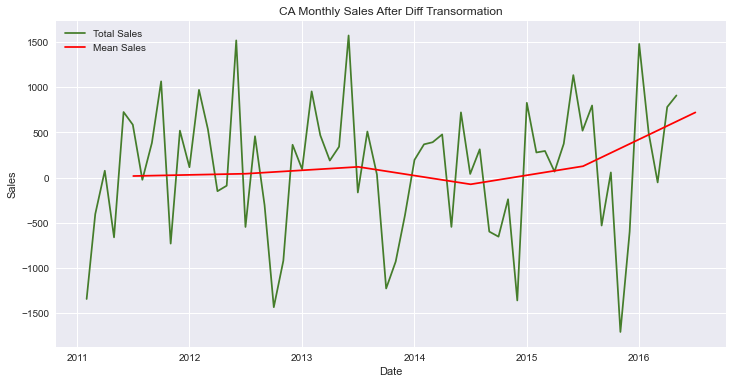

In [12]:
time_plot(ca_diff.reset_index(), 'date', 'sales_diff', 'CA Monthly Sales After Diff Transormation')

In [13]:
test_ca = sm.tsa.stattools.adfuller(ca_diff.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_ca[1]))

ADF p-value for python series: 0.51


*It's not stationary... taking difference and then differencing a second time with `periods=12`*

In [14]:
ca_seasonal_diff = get_seasonal_diff(ca_monthly_df)
ca_seasonal_diff.head()

,item_sales,sales_diff
date,,
2012-02-29,13982.413793,2312.104653
2012-03-31,14516.741935,937.723304
2012-04-30,14366.566667,-226.287097
2012-05-31,14277.354839,571.158065
2012-06-30,15794.866667,792.341935


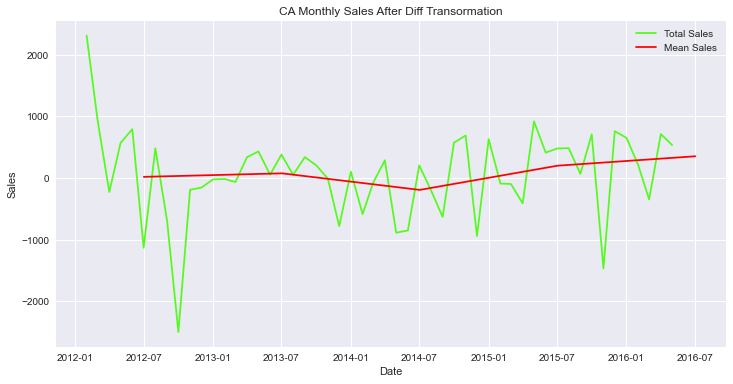

In [15]:
time_plot(ca_seasonal_diff.reset_index(), 'date', 'sales_diff', 'CA Monthly Sales After Diff Transormation')

In [16]:
test_ca = sm.tsa.stattools.adfuller(ca_seasonal_diff.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_ca[1]))

ADF p-value for python series: 0.00


*It's stationary*

In [17]:
ca_seasonal_diff.drop('item_sales', axis=1, inplace=True)
ca_seasonal_diff.head()

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sales_diff
date,
2012-02-29,2312.104653
2012-03-31,937.723304
2012-04-30,-226.287097
2012-05-31,571.158065
2012-06-30,792.341935


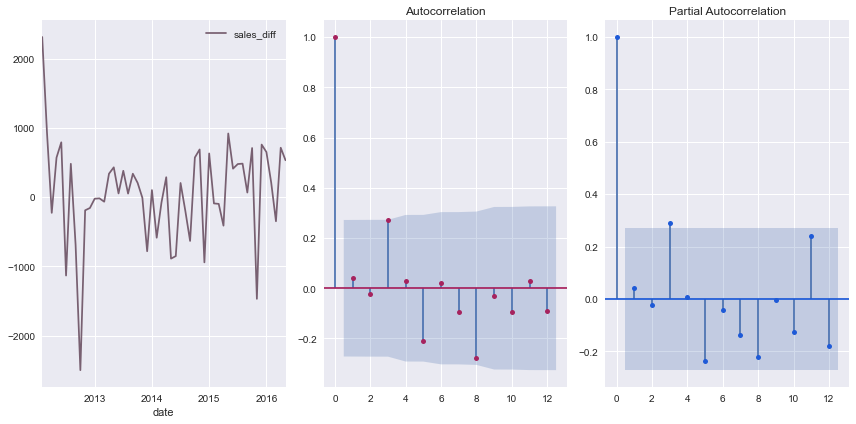

In [18]:
correlation_plots(ca_seasonal_diff, lags=12)

In [21]:
ca_diff.drop('sales_diff', axis=1, inplace=True)
ca_diff.head()

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,item_sales
date,
2011-02-28,11360.750000
2011-03-31,10957.354839
2011-04-30,11033.466667
2011-05-31,10373.096774
2011-06-30,11098.266667


In [25]:
X_train, X_test = train_test_spli(ca_diff)
X_train.shape, X_test.shape

((52, 1), (12, 1))

In [26]:
X_train.head()

,item_sales
date,
2011-02-28,11360.750000
2011-03-31,10957.354839
2011-04-30,11033.466667
2011-05-31,10373.096774
2011-06-30,11098.266667


In [27]:
seasonal_difference_model = sm.tsa.statespace.sarimax.SARIMAX(
                            X_train,
                            order=(1, 1, 0),
                            seasonal_order=(0, 1, 0, 12))
res = seasonal_difference_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         item_sales   No. Observations:                   52
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -308.091
Date:                            Tue, 04 May 2021   AIC                            620.182
Time:                                    13:20:29   BIC                            623.509
Sample:                                02-28-2011   HQIC                           621.376
                                     - 05-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1245      0.153     -0.813      0.416      -0.425       0.176
sigma2      4.223e+05   6.25e+04      6.753      0.000       3e+05    5.45e+05
===================================================================================
Ljung-Box (Q):                       44.53   Jarque-Bera (JB):                33.45
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -1.42
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
y_hat = res.predict(X_test.index[0], X_test.index[-1])

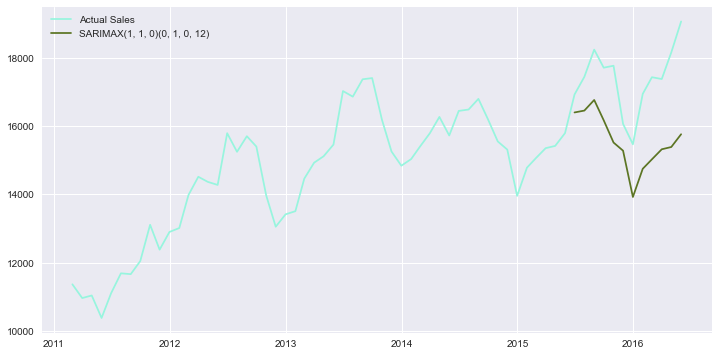

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ca_diff, c=gen_random_color(), label='Actual Sales')
ax.plot(y_hat, c=gen_random_color(), label='SARIMAX(1, 1, 0)(0, 1, 0, 12)')
ax.legend();

In [31]:
np.sum(((X_test.item_sales.values - y_hat)**2)**(1/2))

21877.94195461694